# Base Model

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
import torch
import torch.nn as nn

from sklearn.model_selection import train_test_split

In [3]:
# load normalized data
path_years_norm = "/content/drive/MyDrive/FinalProject/sPINN/data/df_years_norm.csv"
path_days_norm  = "/content/drive/MyDrive/FinalProject/sPINN/data/df_days_norm.csv"

df_years_norm = pd.read_csv(path_years_norm)
df_days_norm  = pd.read_csv(path_days_norm)

In [4]:
# make sliding window dataset
def make_sliding_window(df, window_size, steps_ahead, target_col):
    # get features (everything except target)
    feature_cols = [c for c in df.columns if c != target_col]
    features = df[feature_cols].values.astype(float)

    # target values
    y_full = df[target_col].values.astype(float)

    X_list = []
    y_list = []

    # build sliding windows
    for i in range(len(features) - window_size - steps_ahead):
        window = features[i:i+window_size]
        target = y_full[i + window_size + steps_ahead]

        X_list.append(window)
        y_list.append(target)

    X = np.array(X_list)
    y = np.array(y_list)

    return X, y


In [5]:
# years sliding window
window_size = 12
steps_ahead = 48 * 3   # 3 days ahead

X_years, y_years = make_sliding_window(
    df_years_norm,
    window_size,
    steps_ahead,
    target_col="WVHT"
)

In [6]:
# days sliding window
window_size = 12
steps_ahead = 48 * 3   # 3 days ahead

X_days, y_days = make_sliding_window(
    df_days_norm,
    window_size,
    steps_ahead,
    target_col="WVHT"
)

In [7]:
# plot the first window of a dataset
def plot_first_window(df, window_size, title_name):
    # get feature cols
    feature_cols = [c for c in df.columns]
    features = df[feature_cols].values.astype(float)

    # first window
    first_window = features[:window_size]

    # flip for plotting
    first_window_flipped = first_window.T

    # plot window
    plt.figure(figsize=(10, 6))
    plt.imshow(first_window_flipped, aspect="auto", cmap="viridis")
    plt.title(f"{title_name} Window ({first_window_flipped.shape[0]} features × {first_window_flipped.shape[1]} time steps)")
    plt.xlabel("Time Steps")
    plt.ylabel("Features")
    plt.colorbar()
    plt.show()


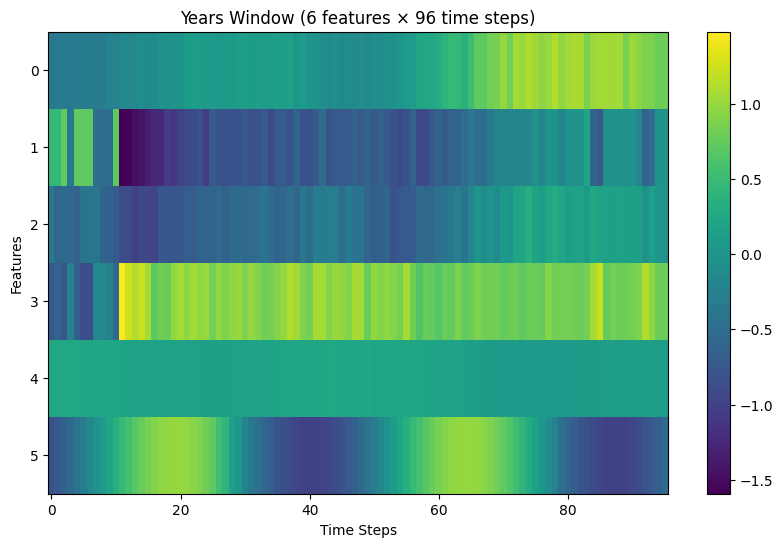

In [8]:
plot_first_window(df_years_norm, window_size=96, title_name="Years")

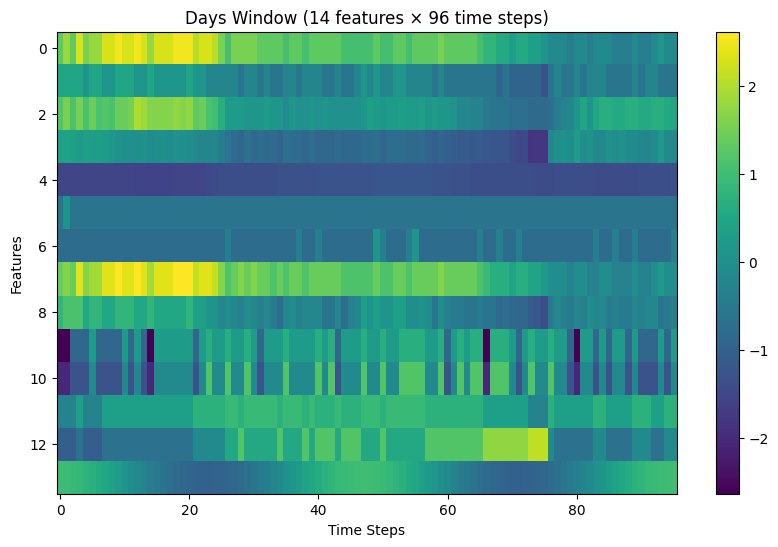

In [9]:
plot_first_window(df_days_norm, window_size=96, title_name="Days")


# RNN

In [10]:
# years sliding window
X_years, y_years = make_sliding_window(df_years_norm, window_size=12, steps_ahead=48*3, target_col="WVHT")

# days sliding window
X_days, y_days = make_sliding_window(df_days_norm, window_size=12, steps_ahead=48*3, target_col="WVHT")

In [11]:
X_years_rnn = X_years.copy()
X_days_rnn  = X_days.copy()

In [12]:
from sklearn.model_selection import train_test_split

# YEARS
X_train_years, X_val_years, y_train_years, y_val_years = train_test_split(
    X_years_rnn, y_years, test_size=0.2, shuffle=False
)

# DAYS
X_train_days, X_val_days, y_train_days, y_val_days = train_test_split(
    X_days_rnn, y_days, test_size=0.2, shuffle=False
)

In [13]:
# YEARS
X_train_years_t = torch.tensor(X_train_years, dtype=torch.float32)
y_train_years_t = torch.tensor(y_train_years, dtype=torch.float32).view(-1, 1)

X_val_years_t = torch.tensor(X_val_years, dtype=torch.float32)
y_val_years_t = torch.tensor(y_val_years, dtype=torch.float32).view(-1, 1)

# DAYS
X_train_days_t = torch.tensor(X_train_days, dtype=torch.float32)
y_train_days_t = torch.tensor(y_train_days, dtype=torch.float32).view(-1, 1)

X_val_days_t = torch.tensor(X_val_days, dtype=torch.float32)
y_val_days_t = torch.tensor(y_val_days, dtype=torch.float32).view(-1, 1)

In [14]:
class WaveLSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim=64, output_dim=1):
        super().__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, batch_first=True)
        self.fc   = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        out, (h, c) = self.lstm(x)
        return self.fc(h[-1])   # final hidden state

In [15]:
input_dim_years = X_years.shape[2]   # 5 features
rnn_years = WaveLSTM(input_dim=input_dim_years, hidden_dim=64, output_dim=1)

input_dim_days = X_days.shape[2]     # 13 features
rnn_days = WaveLSTM(input_dim=input_dim_days, hidden_dim=64, output_dim=1)

In [16]:
optimizer_years = torch.optim.Adam(rnn_years.parameters(), lr=1e-3)
loss_fn = nn.MSELoss()

train_losses_years = []
val_losses_years = []

epochs = 250

for epoch in range(epochs):
    rnn_years.train()
    optimizer_years.zero_grad()
    pred = rnn_years(X_train_years_t)
    loss = loss_fn(pred, y_train_years_t)
    loss.backward()
    optimizer_years.step()

    rnn_years.eval()
    with torch.no_grad():
        val_pred = rnn_years(X_val_years_t)
        val_loss = loss_fn(val_pred, y_val_years_t)

    train_losses_years.append(loss.item())
    val_losses_years.append(val_loss.item())

    if epoch % 25 == 0:
        print(f"[YEARS RNN] Epoch {epoch}: train={loss.item():.4f}, val={val_loss.item():.4f}")

[YEARS RNN] Epoch 0: train=1.2116, val=0.2271
[YEARS RNN] Epoch 25: train=1.1954, val=0.2106
[YEARS RNN] Epoch 50: train=1.1944, val=0.2083
[YEARS RNN] Epoch 75: train=1.1935, val=0.2093
[YEARS RNN] Epoch 100: train=1.1916, val=0.2113
[YEARS RNN] Epoch 125: train=1.1856, val=0.2134
[YEARS RNN] Epoch 150: train=1.1716, val=0.2135
[YEARS RNN] Epoch 175: train=1.1493, val=0.2175
[YEARS RNN] Epoch 200: train=1.1284, val=0.2167
[YEARS RNN] Epoch 225: train=1.1020, val=0.2195


In [17]:
optimizer_days = torch.optim.Adam(rnn_days.parameters(), lr=1e-3)

train_losses_days = []
val_losses_days = []

for epoch in range(epochs):
    rnn_days.train()
    optimizer_days.zero_grad()
    pred = rnn_days(X_train_days_t)
    loss = loss_fn(pred, y_train_days_t)
    loss.backward()
    optimizer_days.step()

    rnn_days.eval()
    with torch.no_grad():
        val_pred = rnn_days(X_val_days_t)
        val_loss = loss_fn(val_pred, y_val_days_t)

    train_losses_days.append(loss.item())
    val_losses_days.append(val_loss.item())

    if epoch % 25 == 0:
        print(f"[DAYS RNN] Epoch {epoch}: train={loss.item():.4f}, val={val_loss.item():.4f}")

[DAYS RNN] Epoch 0: train=1.1501, val=0.3666
[DAYS RNN] Epoch 25: train=0.5449, val=0.9632
[DAYS RNN] Epoch 50: train=0.3308, val=2.5563
[DAYS RNN] Epoch 75: train=0.2674, val=4.2263
[DAYS RNN] Epoch 100: train=0.2175, val=5.7805
[DAYS RNN] Epoch 125: train=0.1743, val=6.3589
[DAYS RNN] Epoch 150: train=0.1274, val=6.5334
[DAYS RNN] Epoch 175: train=0.0791, val=6.9299
[DAYS RNN] Epoch 200: train=0.0441, val=7.0921
[DAYS RNN] Epoch 225: train=0.0264, val=7.2568


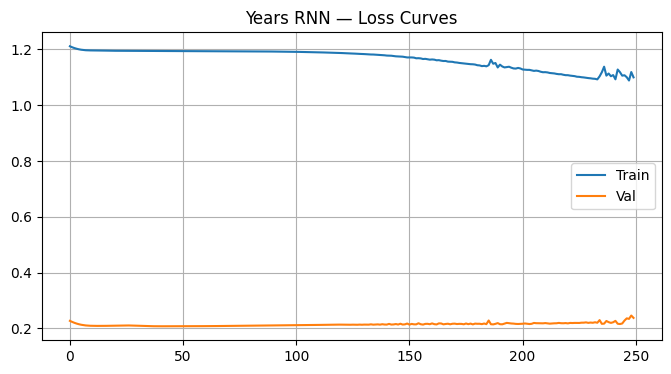

In [18]:
plt.figure(figsize=(8,4))
plt.plot(train_losses_years, label="Train")
plt.plot(val_losses_years, label="Val")
plt.title("Years RNN — Loss Curves")
plt.grid(True); plt.legend()
plt.show()

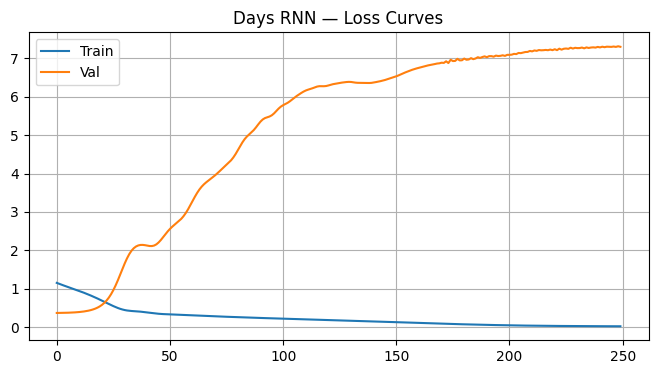

In [19]:
plt.figure(figsize=(8,4))
plt.plot(train_losses_days, label="Train")
plt.plot(val_losses_days, label="Val")
plt.title("Days RNN — Loss Curves")
plt.grid(True); plt.legend()
plt.show()

In [20]:
rnn_years.eval()
rnn_days.eval()

with torch.no_grad():
    pred_years = rnn_years(X_val_years_t).cpu().numpy().flatten()
    pred_days  = rnn_days(X_val_days_t).cpu().numpy().flatten()

real_years = y_val_years.flatten()
real_days  = y_val_days.flatten()

In [21]:
plot_len = 336  # 7 days × 48 samples

real_7       = real_days[:plot_len]
pred_days_7  = pred_days[:plot_len]
pred_years_7 = pred_years[:plot_len]

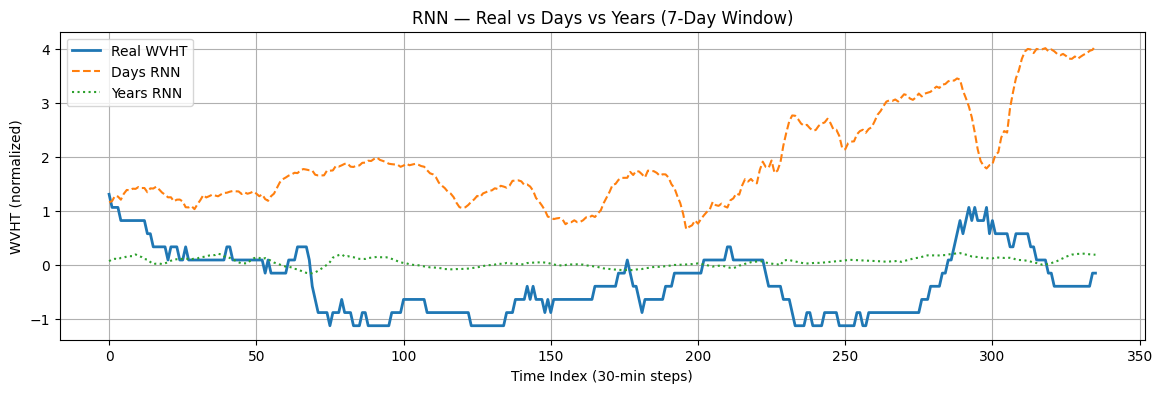

In [22]:
plt.figure(figsize=(14,4))

plt.plot(real_7,       label="Real WVHT", linewidth=2)
plt.plot(pred_days_7,  label="Days RNN", linestyle="--")
plt.plot(pred_years_7, label="Years RNN", linestyle=":")

plt.title("RNN — Real vs Days vs Years (7-Day Window)")
plt.xlabel("Time Index (30-min steps)")
plt.ylabel("WVHT (normalized)")
plt.grid(True)
plt.legend()
plt.show()